<a href="https://colab.research.google.com/github/Pelizzoli/NLP/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.utils import np_utils
from keras.datasets import mnist
from tqdm import tqdm
from nltk.stem.snowball import SnowballStemmer

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = SnowballStemmer("english", ignore_stopwords=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
N_CLASSES = 4

Change file locations form my drive to your drive else you wont be able to run the program. Make sure that the files are changed here else the program wont run correctly.

In addition run each cell in order else it might mess up the run.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/NLP Data Sets/train.csv')
dev = pd.read_csv('/content/drive/MyDrive/NLP Data Sets/dev.csv')
test = pd.read_csv('/content/drive/MyDrive/NLP Data Sets/test.csv')

In [ ]:
train

,tweet_id,text,airline_sentiment
0,569179849518161920,@united you're good. Thank you!,positive
1,569835751275433984,"@AmericanAir way to ruin a vacation, my brothe...",negative
2,568588936852799488,@JetBlue yes thankfully! Catering just got her...,positive
3,569525116725567491,@USAirways The automated message isn't helpful...,negative
4,568807823187976193,@JetBlue I'm #MakingLoveOutofNothingAtAll on m...,positive
...,...,...,...
11853,570123872168574976,"@AmericanAir will not help us on the phone, at...",negative
11854,570063683256242177,@USAirways has the worst customer service line...,negative
11855,568032524749942784,@USAirways grades for this trip:\n\nFlight tim...,negative
11856,569705813142409217,@united Thanks for the vague canned response t...,negative


Preprocessing stage.
Tokenise the data set, stop words taken out, lemmanization, and convierted back into a string. 

In [ ]:
def lemmaWord(word):
    lemma = wordnet.morphy(word)
    if lemma is not None:
        return lemma
    else:
        return word

def preprocess(text, lemma=True, gram=1, rmStop=True):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE)
    tokens = word_tokenize(text)
    new_tokens = ''
    stoplist = stopwordEn if rmStop else []
    for i in tokens:
        i = i.lower()
        if i.isalpha() and (i not in stoplist):
            if lemma: i = lemmaWord(i)
            new_tokens += str(i) + ' '
    del tokens

    # # tokens_series = pd.Series(new_tokens)
    # arg = tf.convert_to_tensor(new_tokens, dtype=tf.string)

    return new_tokens

In [ ]:
train['text'] = train['text'].apply(preprocess)
dev['text'] = dev['text'].apply(preprocess)
train

,tweet_id,text,airline_sentiment
0,569179849518161920,good thank,positive
1,569835751275433984,way ruin vacation brother call night multiple ...,negative
2,568588936852799488,yes thankfully catering get loading frustrate ...,positive
3,569525116725567491,automate message helpful impossible speak huma...,negative
4,568807823187976193,makingloveoutofnothingatall brandloveaffair lax,positive
...,...,...,...
11853,570123872168574976,help us phone gate checkin book travel client ...,negative
11854,570063683256242177,worst customer service line call times today a...,negative
11855,568032524749942784,grade trip flight timeliness cancel flightatio...,negative
11856,569705813142409217,thanks vague can response address issue,negative


In [ ]:
le = LabelEncoder()
le.fit(train['airline_sentiment'])

x_train = train['text']
y_train = le.transform(train['airline_sentiment'])
x_dev = dev['text']
y_dev = le.transform(dev['airline_sentiment'])
x_test = test['text']

In [ ]:
x_train

0                                              good thank 
1        way ruin vacation brother call night multiple ...
2        yes thankfully catering get loading frustrate ...
3        automate message helpful impossible speak huma...
4         makingloveoutofnothingatall brandloveaffair lax 
                               ...                        
11853    help us phone gate checkin book travel client ...
11854    worst customer service line call times today a...
11855    grade trip flight timeliness cancel flightatio...
11856             thanks vague can response address issue 
11857    already airport hr late flightr still guy real...
Name: text, Length: 11858, dtype: object

In [ ]:
y_train

array([2, 0, 2, ..., 0, 0, 0])

**Create a Vocabulary Index**

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'flight', 'get', 'thanks']

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
word_index

{'': 0,
 '[UNK]': 1,
 'flight': 2,
 'get': 3,
 'thanks': 4,
 'cancel': 5,
 'delay': 6,
 'service': 7,
 'customer': 8,
 'help': 9,
 'time': 10,
 'bag': 11,
 'plane': 12,
 'call': 13,
 'amp': 14,
 'us': 15,
 'need': 16,
 'hours': 17,
 'hold': 18,
 'would': 19,
 'thank': 20,
 'try': 21,
 'still': 22,
 'please': 23,
 'one': 24,
 'make': 25,
 'ca': 26,
 'airline': 27,
 'back': 28,
 'gate': 29,
 'flightled': 30,
 'hour': 31,
 'phone': 32,
 'say': 33,
 'guy': 34,
 'change': 35,
 'fly': 36,
 'take': 37,
 'tell': 38,
 'like': 39,
 'late': 40,
 'check': 41,
 'know': 42,
 'go': 43,
 'today': 44,
 'agent': 45,
 'ticket': 46,
 'miss': 47,
 'wait': 48,
 'waiting': 49,
 'airport': 50,
 'want': 51,
 'could': 52,
 'great': 53,
 'u': 54,
 'book': 55,
 'way': 56,
 'going': 57,
 'problem': 58,
 'never': 59,
 'flying': 60,
 'day': 61,
 'weather': 62,
 'tomorrow': 63,
 'really': 64,
 'min': 65,
 'last': 66,
 'even': 67,
 'minutes': 68,
 'see': 69,
 'good': 70,
 'pay': 71,
 'people': 72,
 'seat': 73,
 'home'

**Load Pretrained word embeddings**

Let's download pre-trained GloVe embeddings (a 822M zip file).

You'll need to run the following commands:

!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip -q glove.6B.zip

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [ ]:
path_to_glove_file = "/content/drive/MyDrive/NLP Data Sets/glove.6B.100d.txt"
print (path_to_glove_file)
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

/content/drive/MyDrive/NLP Data Sets/glove.6B.100d.txt
Found 400000 word vectors.


Prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. 

It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6474 words (1645 misses)


In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# **Build the different models**

**Logistic Regression**

In [ ]:
from tensorflow.keras import layers
def build_regression():
    model = Sequential()
    model.add(layers.Input(shape=(200,), dtype="int64"))
    model.add(embedding_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(N_CLASSES, activation="softmax", name='OutputLayer'))
    
    model.compile(
                optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    #logReg.summary()
    return model

**MLP**

In [ ]:
def build_mlp128(hidden_size=128):
    model = Sequential()
    model.add(layers.Input(shape=(200,), dtype="int64"))
    model.add(embedding_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(hidden_size))
    model.add(layers.Dense(N_CLASSES, activation="softmax", name='OutputLayer'))
    
    model.compile(
                optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [ ]:
def build_mlp30(hidden_size=30):
    model = Sequential()
    model.add(layers.Input(shape=(200,), dtype="int64"))
    model.add(embedding_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(hidden_size))
    model.add(layers.Dense(N_CLASSES, activation="softmax", name='OutputLayer'))
    
    model.compile(
                optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

**CNN**

In [ ]:
def build_cnn():

    model = Sequential()
    model.add(layers.Input(shape=(200,), dtype="int64"))
    model.add(embedding_layer)
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(N_CLASSES, activation="softmax", name='OutputLayer')) 
    
    # compile network
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [ ]:
def build_LSTM():

    model = Sequential()
    model.add(layers.Input(shape=(200,), dtype="int64"))
    model.add(embedding_layer)
    model.add(LSTM(100))
    model.add(layers.Dense(N_CLASSES, activation="softmax", name='OutputLayer'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

**Wrap the keras in code to sklearn**


In [ ]:
NUM_EPOCHS = 1 # You can change the number of epochs

In [ ]:
reg = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_regression,
                            epochs=NUM_EPOCHS,
                            verbose=False)
reg._estimator_type = "classifier"

In [ ]:
mlp128 = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_mlp128,
                            epochs=NUM_EPOCHS,
                            verbose=False)
mlp128._estimator_type = "classifier"

In [ ]:
mlp30 = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_mlp30,
                            epochs=NUM_EPOCHS,
                            verbose=False)
mlp30._estimator_type = "classifier"

In [ ]:
cnn = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_cnn,
                            epochs=NUM_EPOCHS,
                            verbose=False)
cnn._estimator_type = "classifier"

In [ ]:
lstm = tf.keras.wrappers.scikit_learn.KerasClassifier(
                            build_LSTM,
                            epochs=NUM_EPOCHS,
                            verbose=False)
lstm._estimator_type = "classifier"

# **Model ensemble: combine different classification models, add your classifiers**

In [ ]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
             estimators=[('mlp128', mlp128),
                         ('mlp30', mlp30),
                         ('reg', reg),
                         ('cnn', cnn),
                         ('lstm', lstm)], 
             voting='soft',
             flatten_transform=True)

In [ ]:
x_train

0                                              good thank 
1        way ruin vacation brother call night multiple ...
2        yes thankfully catering get loading frustrate ...
3        automate message helpful impossible speak huma...
4         makingloveoutofnothingatall brandloveaffair lax 
                               ...                        
11853    help us phone gate checkin book travel client ...
11854    worst customer service line call times today a...
11855    grade trip flight timeliness cancel flightatio...
11856             thanks vague can response address issue 
11857    already airport hr late flightr still guy real...
Name: text, Length: 11858, dtype: object

# **Train the models**

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays
are right-padded.

In [ ]:
# prepare training data
x_train_prep = vectorizer(np.array([[s] for s in x_train])).numpy()
x_dev_prep = vectorizer(np.array([[s] for s in x_dev])).numpy()
x_test_prep = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train_prep = np.array(y_train)
y_dev_prep = np.array(y_dev)

In [ ]:
print(y_train_prep)
print(y_dev_prep)

[2 0 2 ... 0 0 0]
[2 2 0 ... 0 0 2]


In [ ]:
voting.fit(x_train_prep, y_train_prep) # training in sklearn 
reg.fit(x_train_prep, y_train_prep)

In [ ]:
mlp128.fit(x_train_prep, y_train_prep) # training in sklearn 
mlp30.fit(x_train_prep, y_train_prep)
cnn.fit(x_train_prep, y_train_prep)

In [ ]:
# training in Keras directly 
reg_keras=build_regression()
reg_keras.fit(x_train_prep, y_train_prep, batch_size=128, epochs=20, validation_data=(x_dev_prep, y_dev_prep))
# prediction
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
reg_preds = reg_keras(x)
reg_end_to_end_model = keras.Model(string_input, reg_preds)


Epoch 1/20
93/93 [==============================] - 2s 15ms/step - loss: 0.8765 - accuracy: 0.6425 - val_loss: 0.7204 - val_accuracy: 0.7215
Epoch 2/20
93/93 [==============================] - 1s 13ms/step - loss: 0.6599 - accuracy: 0.7369 - val_loss: 0.6851 - val_accuracy: 0.7284
Epoch 3/20
93/93 [==============================] - 1s 13ms/step - loss: 0.6150 - accuracy: 0.7475 - val_loss: 0.6731 - val_accuracy: 0.7307
Epoch 4/20
93/93 [==============================] - 1s 13ms/step - loss: 0.5944 - accuracy: 0.7528 - val_loss: 0.6715 - val_accuracy: 0.7291
Epoch 5/20
93/93 [==============================] - 1s 13ms/step - loss: 0.5697 - accuracy: 0.7654 - val_loss: 0.6656 - val_accuracy: 0.7314
Epoch 6/20
93/93 [==============================] - 1s 14ms/step - loss: 0.5606 - accuracy: 0.7676 - val_loss: 0.6665 - val_accuracy: 0.7299
Epoch 7/20
93/93 [==============================] - 1s 13ms/step - loss: 0.5439 - accuracy: 0.7727 - val_loss: 0.6646 - val_accuracy: 0.7291
Epoch 8/20
93

In [ ]:
# training in Keras directly 
mlp128_keras=build_mlp128()
mlp128_keras.fit(x_train_prep, y_train_prep, batch_size=128, epochs=20, validation_data=(x_dev_prep, y_dev_prep))
# prediction
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
mlp128_preds = mlp128_keras(x)
mlp128_end_to_end_model = keras.Model(string_input, mlp128_preds)


Epoch 1/20
93/93 [==============================] - 4s 41ms/step - loss: 0.8662 - accuracy: 0.6536 - val_loss: 0.6947 - val_accuracy: 0.7071
Epoch 2/20
93/93 [==============================] - 4s 40ms/step - loss: 0.6255 - accuracy: 0.7446 - val_loss: 0.6754 - val_accuracy: 0.7200
Epoch 3/20
93/93 [==============================] - 4s 40ms/step - loss: 0.5711 - accuracy: 0.7618 - val_loss: 0.7080 - val_accuracy: 0.7185
Epoch 4/20
93/93 [==============================] - 4s 40ms/step - loss: 0.5595 - accuracy: 0.7685 - val_loss: 0.7239 - val_accuracy: 0.7185
Epoch 5/20
93/93 [==============================] - 4s 39ms/step - loss: 0.5520 - accuracy: 0.7695 - val_loss: 0.7080 - val_accuracy: 0.7056
Epoch 6/20
93/93 [==============================] - 4s 40ms/step - loss: 0.5334 - accuracy: 0.7761 - val_loss: 0.7695 - val_accuracy: 0.7140
Epoch 7/20
93/93 [==============================] - 4s 39ms/step - loss: 0.5350 - accuracy: 0.7726 - val_loss: 0.7314 - val_accuracy: 0.7056
Epoch 8/20
93

In [ ]:
# training in Keras directly 
mlp30_keras=build_mlp30()
mlp30_keras.fit(x_train_prep, y_train_prep, batch_size=128, epochs=20, validation_data=(x_dev_prep, y_dev_prep))
# prediction
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
mlp30_preds = mlp30_keras(x)
mlp30_end_to_end_model = keras.Model(string_input, mlp30_preds)


Epoch 1/20
93/93 [==============================] - 2s 21ms/step - loss: 0.8315 - accuracy: 0.6553 - val_loss: 0.7361 - val_accuracy: 0.6844
Epoch 2/20
93/93 [==============================] - 2s 18ms/step - loss: 0.6164 - accuracy: 0.7430 - val_loss: 0.6803 - val_accuracy: 0.7132
Epoch 3/20
93/93 [==============================] - 2s 19ms/step - loss: 0.5716 - accuracy: 0.7686 - val_loss: 0.6995 - val_accuracy: 0.7215
Epoch 4/20
93/93 [==============================] - 2s 18ms/step - loss: 0.5607 - accuracy: 0.7684 - val_loss: 0.7187 - val_accuracy: 0.7086
Epoch 5/20
93/93 [==============================] - 2s 18ms/step - loss: 0.5381 - accuracy: 0.7770 - val_loss: 0.7186 - val_accuracy: 0.7132
Epoch 6/20
93/93 [==============================] - 2s 19ms/step - loss: 0.5230 - accuracy: 0.7841 - val_loss: 0.7297 - val_accuracy: 0.7170
Epoch 7/20
93/93 [==============================] - 2s 19ms/step - loss: 0.5254 - accuracy: 0.7867 - val_loss: 0.7283 - val_accuracy: 0.7132
Epoch 8/20
93

In [ ]:
# training in Keras directly 
cnn_keras=build_cnn()
cnn_keras.fit(x_train_prep, y_train_prep, batch_size=128, epochs=20, validation_data=(x_dev_prep, y_dev_prep))
# prediction
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
cnn_preds = cnn_keras(x)
cnn_end_to_end_model = keras.Model(string_input, cnn_preds)


Epoch 1/20
93/93 [==============================] - 10s 102ms/step - loss: 0.8861 - accuracy: 0.6338 - val_loss: 0.7160 - val_accuracy: 0.7185
Epoch 2/20
93/93 [==============================] - 9s 100ms/step - loss: 0.6519 - accuracy: 0.7369 - val_loss: 0.6571 - val_accuracy: 0.7231
Epoch 3/20
93/93 [==============================] - 9s 100ms/step - loss: 0.5775 - accuracy: 0.7651 - val_loss: 0.6568 - val_accuracy: 0.7246
Epoch 4/20
93/93 [==============================] - 9s 100ms/step - loss: 0.5368 - accuracy: 0.7811 - val_loss: 0.6636 - val_accuracy: 0.7094
Epoch 5/20
93/93 [==============================] - 9s 100ms/step - loss: 0.5195 - accuracy: 0.7870 - val_loss: 0.6259 - val_accuracy: 0.7436
Epoch 6/20
93/93 [==============================] - 9s 101ms/step - loss: 0.4851 - accuracy: 0.8046 - val_loss: 0.6306 - val_accuracy: 0.7322
Epoch 7/20
93/93 [==============================] - 9s 100ms/step - loss: 0.4586 - accuracy: 0.8195 - val_loss: 0.6392 - val_accuracy: 0.7405
Epoch

In [ ]:
lstm_keras=build_LSTM()
lstm_keras.fit(x_train_prep, y_train_prep, batch_size=128, epochs=20, validation_data=(x_dev_prep, y_dev_prep))
# prediction
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
lstm_preds = lstm_keras(x)
lstm_end_to_end_model = keras.Model(string_input, lstm_preds)

Epoch 1/20
93/93 [==============================] - 42s 425ms/step - loss: 1.0681 - accuracy: 0.6271 - val_loss: 0.9231 - val_accuracy: 0.6267
Epoch 2/20
93/93 [==============================] - 39s 419ms/step - loss: 0.9322 - accuracy: 0.6190 - val_loss: 0.9181 - val_accuracy: 0.6267
Epoch 3/20
93/93 [==============================] - 39s 415ms/step - loss: 0.9142 - accuracy: 0.6318 - val_loss: 0.9230 - val_accuracy: 0.6267
Epoch 4/20
93/93 [==============================] - 38s 413ms/step - loss: 0.9219 - accuracy: 0.6239 - val_loss: 0.9254 - val_accuracy: 0.6267
Epoch 5/20
93/93 [==============================] - 38s 413ms/step - loss: 0.9199 - accuracy: 0.6263 - val_loss: 0.9208 - val_accuracy: 0.6267
Epoch 6/20
93/93 [==============================] - 39s 415ms/step - loss: 0.9165 - accuracy: 0.6287 - val_loss: 0.9172 - val_accuracy: 0.6267
Epoch 7/20
93/93 [==============================] - 39s 416ms/step - loss: 0.9273 - accuracy: 0.6192 - val_loss: 0.9182 - val_accuracy: 0.6267

# **predict the results for each model**

In [ ]:
y_dev_pred_reg = reg.predict(x_dev_prep)
y_dev_pred_mlp128 = mlp128.predict(x_dev_prep)
y_dev_pred_mlp30 = mlp30.predict(x_dev_prep)
y_dev_pred_voting = voting.predict(x_dev_prep)
y_dev_pred_cnn = cnn.predict(x_dev_prep)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Text(0.5, 1.0, 'F1 score for each model')

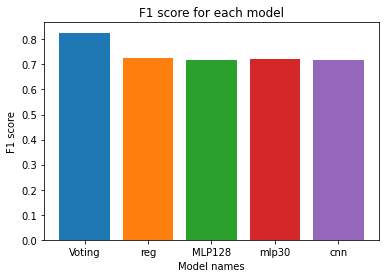

In [ ]:
plt.figure
f1_reg = f1_score(y_dev, y_dev_pred_reg, average='micro')
f1_mlp128 = f1_score(y_dev, y_dev_pred_mlp128, average='micro')
f1_mlp30 = f1_score(y_dev, y_dev_pred_mlp30, average='micro')
f1_cnn = f1_score(y_dev, y_dev_pred_cnn, average='micro')
f1_voting = f1_score(y_dev, y_dev_pred_voting, average=None)

f1s = [f1_voting, f1_reg, f1_mlp128, f1_mlp30, f1_cnn]
model_names = ['Voting', 'reg', 'MLP128', 'mlp30', 'cnn']
for i in range(len(model_names)):
    f1 = f1s[i]
    model_name = model_names[i]
    plt.bar(model_name, f1)



plt.xlabel('Model names')
plt.ylabel('F1 score')
plt.title('F1 score for each model')

# Predict the test set 


In [ ]:
y_pred = voting.predict(x_test_prep)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
y_pred

array([0, 0, 0, ..., 2, 0, 0])

In [ ]:
pred_labels = le.inverse_transform(y_pred)
test['airline_sentiment'] = pred_labels
test.to_csv('test.csv', index=False)

In [ ]:
test

,tweet_id,text,airline_sentiment
0,570251814970515456,@AmericanAir I need refund.,negative
1,568173388663013377,@USAirways after 3 Cancelled Flightlations and...,negative
2,569320520728113152,@JetBlue thanks so much. Can't wait to fly wit...,negative
3,569503367757754369,@united I have never been more frustrated than...,negative
4,568981079278751744,"@USAirways - the worst! Hold time crazy, agent...",negative
...,...,...,...
1459,569678153783877634,@AmericanAir I didn't miss my flight. America...,negative
1460,569882442129133568,@USAirways here's to sitting on hold for 4 hrs...,negative
1461,568192010789777408,@SouthwestAir just had a great flight #4223 wi...,positive
1462,569774692371820544,@AmericanAir Why did AA973 return to JFK? Tha...,negative


In [ ]:
test['airline_sentiment'].value_counts()

negative    1274
positive     121
neutral       69
Name: airline_sentiment, dtype: int64

# **References and citations**
scikit-learn  1.11.6. Voting Classifier https://scikit-learn.org/stable/modules/ensemble.html 

Keras word embeddings: https://keras.io/examples/nlp/pretrained_word_embeddings/ 

Keras models with scikit learn: https://www.kaggle.com/residentmario/using-keras-models-with-scikit-learn-pipelines

Practical 3, which feature is helpful for female name classification. https://www.nltk.org/book/ch06.html

research paper: https://github.com/yoonkim/CNN_sentence

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html 

https://www.nltk.org/book/ch06.html 

Other online resources: 

https://towardsdatascience.com/setting-up-text-preprocessing-pipeline-using-scikit-learn-and-spacy-e09b9b76758f

how to encode text data https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/#:~:text=The%20CountVectorizer%20provides%20a%20simple,can%20use%20it%20as%20follows%3A&text=Call%20the%20transform()%20function,encode%20each%20as%20a%20vector.

cnn model: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

lstm model: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/